In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
from livecell_tracker import segment
from livecell_tracker import core
from livecell_tracker.core import datasets
from livecell_tracker.core.datasets import LiveCellImageDataset
from skimage import measure
from livecell_tracker.core import SingleCellTrajectory, SingleCellStatic
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from livecell_tracker.segment.detectron_utils import gen_cfg

from livecell_tracker.segment.detectron_utils import (
    segment_detectron_wrapper,
    segment_images_by_detectron,
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
)
from livecell_tracker.segment.detectron_utils import convert_detectron_instance_pred_masks_to_binary_masks, convert_detectron_instances_to_label_masks, segment_images_by_detectron, segment_single_img_by_detectron_wrapper

pretrained_model_path = r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
# seg_out_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
model_dir = Path(r"""./notebook_results/train_log/detectron_train_output__ver0.0.2/""")
out_dir = Path(r"./day0_output")
seg_out_dir = out_dir / "segmentation"
track_out_dir = out_dir / "tracking"
segmentation_result_json_path = seg_out_dir / "segmentation_results.json"
trajectory_collection_path = track_out_dir / "trajectory_collection.json"
assert os.path.exists(model_dir)
os.makedirs(seg_out_dir, exist_ok=True)
os.makedirs(track_out_dir, exist_ok=True)
pretrained_model_path = r"./notebook_results/train_log/detectron_train_output__ver0.0.2/model_final.pth"
dataset_dir_path = "../cxa-data/june_2022_data_8bit_png/restart_day0_Group 1_wellA1_RI_MIP_stitched"

In [ ]:
imgs = core.datasets.LiveCellImageDataset(dataset_dir_path, ext="png", num_imgs=None)

## Segmentation

In [ ]:
DETECTRON_CFG = gen_cfg(
    model_path=pretrained_model_path,
    output_dir=str(model_dir),
);
DETECTRON_PREDICTOR = DefaultPredictor(DETECTRON_CFG);

In [ ]:
seg_out_dir = Path(seg_out_dir)
segmentation_results = segment_images_by_detectron(imgs,seg_out_dir, cfg=DETECTRON_CFG)
with open(seg_out_dir / "segmentation_results.json", "w+") as f:
    json.dump(segmentation_results, f)

## Tracking

In [ ]:
raw_imgs = LiveCellImageDataset(dataset_dir_path, ext="png")

segmentation_results = json.load(open(segmentation_result_json_path, "r"))
segmentation_results;

In [ ]:
from livecell_tracker.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours
)

In [ ]:
MAX_AGE, MIN_HITS = 5, 3
trajectory_collection = track_SORT_bbox_from_contours(segmentation_results, raw_imgs, max_age=MAX_AGE, min_hits=MIN_HITS)

In [ ]:
trajectory_collection.histogram_traj_length()
plt.title("Length distribution of trajectories")
plt.ylabel("Count")
plt.xlabel("Trajectory length")
plt.show()

In [ ]:
trajectory_collection.write_json(trajectory_collection_path)

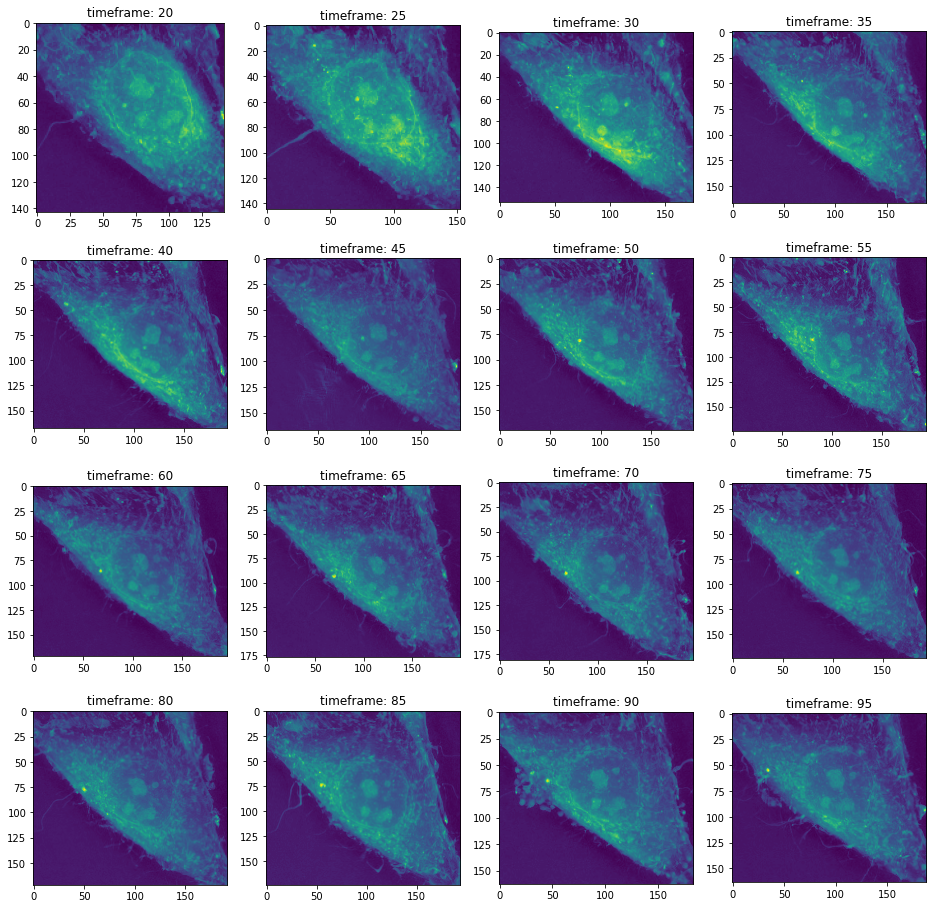

In [14]:
import matplotlib.pyplot as plt
nr = 4
nc = 4
track_id = 5
start_timeframe = 20
interval = 5
fig, axes= plt.subplots(nr, nc, figsize=(nc*4, nr*4))
for r in range(nr):
    for c in range(nc):
        timeframe = start_timeframe + interval * (r * nc + c)
        sc = trajectory_collection.track_id_to_trajectory[track_id].get_single_cell(timeframe)
        sc_img = sc.get_img_crop()
        axes[r, c].imshow(sc_img)
        # trajectory_collection[timeframe].plot(axes[r, c])
        axes[r, c].set_title(f"timeframe: {timeframe}")

## Trajectory analysis

In [2]:
from livecell_tracker.core.single_cell import SingleCellTrajectoryCollection

traj_collection_json = json.load(open(trajectory_collection_path, "r"))
trajectory_collection = SingleCellTrajectoryCollection().load_from_json_dict(traj_collection_json)

<AxesSubplot:ylabel='Count'>

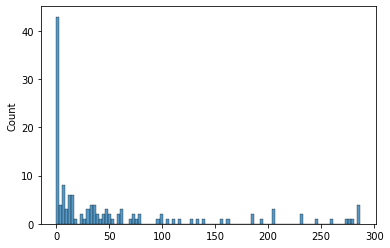

In [3]:
trajectory_collection.histogram_traj_length()

In [13]:
for traj in trajectory_collection:
    print(traj.get_timeframe_span_range(), end=",")

(0, 1),(0, 0),(0, 36),(0, 37),(0, 53),(0, 0),(0, 6),(0, 246),(0, 138),(0, 287),(0, 78),(0, 98),(0, 17),(0, 39),(0, 13),(0, 2),(0, 43),(0, 287),(0, 276),(0, 274),(0, 95),(0, 193),(0, 287),(0, 128),(0, 281),(0, 100),(0, 72),(0, 287),(0, 232),(1, 46),(1, 1),(2, 2),(2, 2),(9, 9),(10, 21),(10, 16),(11, 15),(12, 37),(18, 67),(19, 19),(28, 287),(28, 30),(28, 100),(31, 31),(35, 42),(36, 67),(38, 45),(39, 77),(40, 72),(40, 41),(41, 43),(41, 87),(42, 43),(42, 74),(45, 46),(47, 47),(47, 107),(50, 50),(56, 287),(60, 60),(60, 75),(60, 135),(62, 62),(63, 125),(63, 69),(64, 125),(65, 81),(67, 115),(68, 68),(71, 88),(73, 81),(74, 118),(79, 284),(81, 81),(81, 287),(82, 237),(82, 287),(91, 103),(92, 119),(94, 94),(96, 100),(96, 98),(98, 98),(101, 287),(103, 287),(104, 116),(106, 120),(107, 223),(107, 107),(109, 213),(110, 110),(110, 181),(112, 112),(115, 138),(120, 120),(124, 287),(125, 130),(126, 126),(127, 127),(131, 179),(141, 199),(151, 285),(155, 157),(159, 160),(163, 193),(163, 273),(170, 232),(17